# MobileNetV2

In [1]:
from PIL import Image
import numpy as np
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


# case 1
warm_1(05번) 490장 + cool_1 186장 "총 676장"        
6:4 random state = 42       
dense layer 1, sigmoid, binary_crossentropy   
데이터 증강 0, epochs = 30, batch_size=32    

## 데이터 불러오고, 웜톤 0, 쿨톤 1로 레이블링

In [103]:
def load_data(img_path, number_of_data=676):  # 웜톤 490 + 쿨톤 186
    # 웜톤 : 0, 쿨톤 : 1
    img_size=224
    color=3
    #이미지 데이터와 라벨(웜톤 : 0, 쿨톤 : 1) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    warm_files = list(glob.iglob(img_path + '/warm_1/*.jpg')) + list(glob.iglob(img_path + '/warm_1/*.JPG'))
    for file in warm_files:
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 웜톤 : 0
        idx=idx+1

    cool_files = list(glob.iglob(img_path + '/cool_1/*.jpg')) + list(glob.iglob(img_path + '/cool_1/*.JPG'))
    for file in cool_files:
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 쿨톤 : 1
        idx=idx+1  
    
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/aiffelthon"
(x_train, y_train)=load_data(image_dir_path)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 676 입니다.
x_train shape: (676, 224, 224, 3)
y_train shape: (676,)


## train data, validation data 나누기, 정규화

In [13]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [104]:
# x_train과 y_train을 훈련 세트와 검증 세트로 분할
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

In [105]:
x_train.dtype

dtype('int32')

In [106]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

In [107]:
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_val shape: {}".format(x_val.shape))
print("y_val shape: {}".format(y_val.shape))

x_train shape: (405, 224, 224, 3)
y_train shape: (405,)
x_val shape: (271, 224, 224, 3)
y_val shape: (271,)


In [88]:
type(x_val)

numpy.ndarray

## 데이터 증강

In [108]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강을 위한 ImageDataGenerator 인스턴스 생성
datagen = ImageDataGenerator(
    rescale=1./255,        # 이미지 픽셀 값을 [0,1] 범위로 스케일링
    rotation_range=20,     # 0-20도 범위에서 랜덤하게 이미지를 회전
    width_shift_range=0.2, # 이미지를 수평으로 랜덤하게 이동 (전체 너비의 20% 내에서)
    height_shift_range=0.2,# 이미지를 수직으로 랜덤하게 이동 (전체 높이의 20% 내에서)
    horizontal_flip=True   # 이미지를 랜덤하게 수평으로 뒤집기
)

# ImageDataGenerator를 학습 데이터에 적용
datagen.fit(x_train)

In [ ]:
# 상하반전 vertical_flip는 false가 디폴트라고 함

In [ ]:
# 이렇게 생성된 datagen은 데이터 증강이 적용된 이미지를 배치 단위로 생성할 수 있습니다. 
# 이를 학습 과정에 사용하려면, fit 메소드 대신 fit_generator 메소드를 사용하고, datagen.flow를 입력으로 제공하면 됩니다:

In [ ]:
# ImageDataGenerator를 사용하면, 데이터 증강이 적용된 이미지는 자동으로 텐서로 변환됩니다. 
# ImageDataGenerator의 flow 메소드는 데이터 증강이 적용된 이미지를 배치 단위로 생성하며, 이때 각 배치는 텐서 형태로 반환됩니다. 
# 따라서, ImageDataGenerator를 사용하여 데이터 증강을 적용한 후에는 별도로 텐서로 변환할 필요가 없습니다.

# 또한, ImageDataGenerator의 rescale 매개변수를 사용하여 이미지 픽셀 값을 [0,1] 범위로 스케일링하는 것도 가능합니다. 
# 이는 모델에 입력되는 데이터의 스케일을 일정하게 유지하여, 모델의 학습을 안정화하는 데 도움이 됩니다.

# 따라서, 데이터 증강 후에는 별도로 텐서로 변환하지 않아도 됩니다. 
# ImageDataGenerator를 사용하면, 데이터 증강과 텐서 변환, 스케일링 등의 전처리 과정이 한 번에 처리됩니다.

## MobileNetV2 모델 쌓기

In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [109]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(1, activation='sigmoid'))  # 출력 레이어 추가

In [110]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_6 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 62721     
Total params: 2,320,705
Trainable params: 2,286,593
Non-trainable params: 34,112
_________________________________________________________________


In [111]:
# 모델 컴파일
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


# 학습 데이터에 데이터 증강 적용
train_generator = datagen.flow(x_train, y_train, batch_size=32)

In [ ]:
# ImageDataGenerator를 사용하면, 각 에포크마다 원본 학습 데이터에 새로운 데이터 증강이 적용됩니다. 
# 그러나 이는 원본 데이터를 변형하여 새로운 데이터를 생성하는 것이지, 원본 데이터의 총량을 증가시키는 것은 아닙니다.

# 즉, 한 에포크 동안 학습에 사용되는 데이터의 총량은 여전히 len(x_train)입니다. 
# 다만, 각 에포크마다 데이터 증강을 통해 생성된 데이터가 다르므로, 모델은 매 에포크마다 다양한 형태의 데이터를 보게 됩니다.

# 따라서, 데이터 증강이 적용되더라도 한 에포크마다 학습에 사용되는 데이터의 총량은 변하지 않습니다. 
# 다만, 각 에포크마다 학습에 사용되는 데이터의 형태는 다르게 됩니다.

In [112]:
hist = model.fit(train_generator, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
13/13 [==============================] - 10s 413ms/step - loss: 1.2794 - accuracy: 0.7753 - val_loss: 4.6892 - val_accuracy: 0.7491
Epoch 2/30
13/13 [==============================] - 5s 338ms/step - loss: 0.4218 - accuracy: 0.8444 - val_loss: 13.7493 - val_accuracy: 0.7491
Epoch 3/30
13/13 [==============================] - 5s 336ms/step - loss: 0.2243 - accuracy: 0.9086 - val_loss: 16.2348 - val_accuracy: 0.7491
Epoch 4/30
13/13 [==============================] - 4s 329ms/step - loss: 0.1879 - accuracy: 0.9210 - val_loss: 17.2272 - val_accuracy: 0.7491
Epoch 5/30
13/13 [==============================] - 5s 337ms/step - loss: 0.1653 - accuracy: 0.9457 - val_loss: 14.6541 - val_accuracy: 0.7491
Epoch 6/30
13/13 [==============================] - 5s 342ms/step - loss: 0.1102 - accuracy: 0.9506 - val_loss: 15.1257 - val_accuracy: 0.7491
Epoch 7/30
13/13 [==============================] - 5s 356ms/step - loss: 0.0836 - accuracy: 0.9605 - val_loss: 17.5663 - val_accuracy: 0.7491

## loss, accuracy 시각화

In [113]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

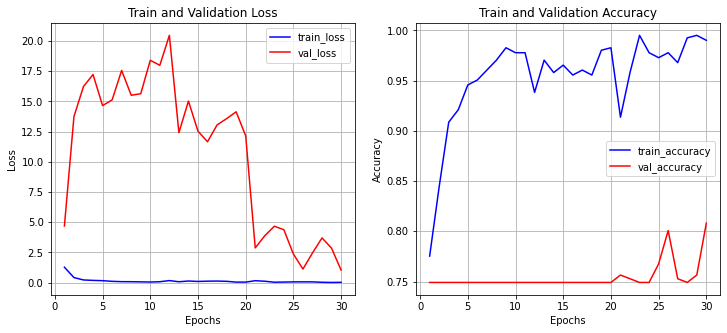

In [114]:
history_dict = hist.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

### 그래프를 봐서는.. epochs을 조금 더 늘려봐야 하나?

## confusion_matrix 출력

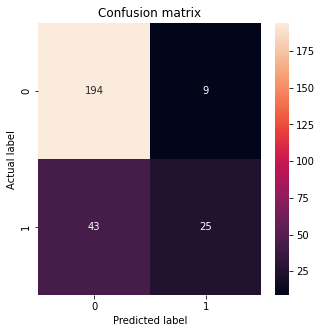

In [115]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 검증 데이터셋에 대한 예측 생성
y_pred = model.predict(x_val)
y_pred = np.round(y_pred).astype(int)

# confusion matrix 생성
cm = confusion_matrix(y_val, y_pred)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### 다 더하면 271인데.. 
### 웜톤은 잘 분류하는 것 같은데, 쿨톤을 웜톤으로 잘못 분류하고 있다고 해석하면 될까?

## validation data에 대해 모델 평가

In [116]:
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
    

In [117]:
y_pred.shape

(271, 1)

In [118]:
test_score=model.evaluate(x_val, y_val)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1]*100))

9/9 [==============================] - 0s 41ms/step - loss: 1.0410 - accuracy: 0.8081
Test loss 1.0410, accuracy 80.81%


In [ ]:
# model.evaluate: 이 메서드는 모델의 성능을 평가하는 데 사용됩니다. 
#     주어진 입력 데이터에 대해 모델의 손실(loss)과 메트릭(metric) 값을 계산합니다. 
#     예를 들어, 분류 문제에서는 정확도(accuracy)를, 회귀 문제에서는 평균 제곱 오차(mean squared error)를 계산할 수 있습니다. 
#     이 메서드는 손실과 메트릭의 값이 얼마나 좋은지(즉, 모델의 성능이 얼마나 좋은지)를 알려줍니다.

# model.predict: 이 메서드는 주어진 입력에 대한 모델의 출력(예측)을 계산합니다. 
#     이 메서드는 모델이 학습한 패턴을 기반으로 새로운 데이터에 대한 예측을 생성하는 데 사용됩니다. 
#     예를 들어, 이미지 분류 모델에서는 새로운 이미지가 주어졌을 때 각 클래스에 속할 확률을 출력하고, 
#     회귀 모델에서는 새로운 입력에 대한 연속적인 출력 값을 생성합니다.

# 따라서, model.evaluate는 모델의 성능을 평가하고, model.predict는 새로운 데이터에 대한 예측을 생성하는 데 사용됩니다.

In [120]:
# y_pred = model.predict(x_val)
# y_pred = np.round(y_pred).astype(int)
# 위 confusion matrix에서 사용함
y_val = np.array(y_val)

In [ ]:
# np.round(y_pred).astype(int)를 사용하여 이미 이진 분류 예측을 0 또는 1로 변환했다면, 
# np.argmax(y_pred, axis=1)는 필요하지 않습니다. 
# np.argmax는 다중 클래스 분류 문제에서 각 클래스에 대한 확률을 예측한 후, 가장 확률이 높은 클래스를 선택할 때 사용됩니다. 
# 이진 분류 문제에서는 np.round를 사용하여 예측을 반올림하면 충분합니다.

In [121]:
print(y_pred)
print(y_val)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]


In [ ]:
# y_pred와 y_val이 모두 1차원 배열로 변환되어야 합니다. 현재 y_pred는 2차원 배열로 보입니다. 
# np.squeeze 함수를 사용하여 불필요한 차원을 제거할 수 있습니다. 이 함수는 배열에서 1차원을 제거합니다.

In [122]:
y_pred = np.squeeze(y_pred)
y_val = np.squeeze(y_val)

print(y_pred)
print(y_val)

[0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 1 0 1 1 0 0 1 0 0 0 0 0]
[1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0
 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1
 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0
 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0

## classification_report

In [123]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       203
           1       0.74      0.37      0.49        68

    accuracy                           0.81       271
   macro avg       0.78      0.66      0.69       271
weighted avg       0.80      0.81      0.78       271



# case 2
warm_1(05번) 490장 + cool_1 186장 "총 676장"           
6:4 random state = 42            
dense layer 2, softmax, categorical_crossentropy, y_train y_val -> 원핫인코딩       
데이터 증강 0, epochs = 50, batch_size=32     

## 224*224로 resize (case 1은 안 한 것 같아...)

In [176]:
def resize_images(img_path):
#     images=glob.glob(img_path + "/*.jpg")  
    images = glob.glob(img_path + "/*.jpg") + glob.glob(img_path + "/*.JPG")
    print(len(images), " images to be resized.")

    # 파일마다 모두 224x224 사이즈로 바꾸어 저장
    target_size=(224,224)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

# 쿨톤 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/aiffelthon/warm_1"
resize_images(image_dir_path)

print("웜톤 이미지 resize 완료!")

490  images to be resized.
490  images resized.
웜톤 이미지 resize 완료!


In [177]:
# 쿨톤 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/aiffelthon/cool_1"
resize_images(image_dir_path)

print("쿨톤 이미지 resize 완료!")

186  images to be resized.
186  images resized.
쿨톤 이미지 resize 완료!


## 데이터 불러오고 웜톤 0 쿨톤 1로 레이블링

In [178]:
def load_data(img_path, number_of_data=676):  # 웜톤 490 + 쿨톤 186
    # 웜톤 : 0, 쿨톤 : 1
    img_size=224
    color=3
    #이미지 데이터와 라벨(웜톤 : 0, 쿨톤 : 1) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    warm_files = list(glob.iglob(img_path + '/warm_1/*.jpg')) + list(glob.iglob(img_path + '/warm_1/*.JPG'))
    for file in warm_files:
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 웜톤 : 0
        idx=idx+1

    cool_files = list(glob.iglob(img_path + '/cool_1/*.jpg')) + list(glob.iglob(img_path + '/cool_1/*.JPG'))
    for file in cool_files:
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 쿨톤 : 1
        idx=idx+1  
    
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/aiffelthon"
(x_train, y_train)=load_data(image_dir_path)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 676 입니다.
x_train shape: (676, 224, 224, 3)
y_train shape: (676,)


## train data, validation data 나누기, 정규화

In [179]:
# x_train과 y_train을 훈련 세트와 검증 세트로 분할
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

In [180]:
x_train.dtype

dtype('int32')

In [181]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

In [182]:
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_val shape: {}".format(x_val.shape))
print("y_val shape: {}".format(y_val.shape))

x_train shape: (405, 224, 224, 3)
y_train shape: (405,)
x_val shape: (271, 224, 224, 3)
y_val shape: (271,)


## 데이터 증강

In [184]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강을 위한 ImageDataGenerator 인스턴스 생성
datagen = ImageDataGenerator(
    rescale=1./255,        # 이미지 픽셀 값을 [0,1] 범위로 스케일링
    rotation_range=20,     # 0-20도 범위에서 랜덤하게 이미지를 회전
    width_shift_range=0.2, # 이미지를 수평으로 랜덤하게 이동 (전체 너비의 20% 내에서)
    height_shift_range=0.2,# 이미지를 수직으로 랜덤하게 이동 (전체 높이의 20% 내에서)
    horizontal_flip=True   # 이미지를 랜덤하게 수평으로 뒤집기
)

# ImageDataGenerator를 학습 데이터에 적용
datagen.fit(x_train)

## MobileNetV2 모델 쌓기

In [185]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [186]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [187]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_10 (Flatten)         (None, 62720)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 125442    
Total params: 2,383,426
Trainable params: 2,349,314
Non-trainable params: 34,112
_________________________________________________________________


## 소프트맥스를 쓰려면 레이블이 원핫인코딩이 되어야한다!!

In [188]:
from tensorflow.keras.utils import to_categorical

# 레이블을 원-핫 인코딩 형태로 변환
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [189]:
# 모델 컴파일
model.compile(optimizer=Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# 학습 데이터에 데이터 증강 적용
train_generator = datagen.flow(x_train, y_train, batch_size=32)

In [190]:
hist = model.fit(train_generator, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
13/13 [==============================] - 9s 429ms/step - loss: 1.7563 - accuracy: 0.7136 - val_loss: 41.5492 - val_accuracy: 0.7491
Epoch 2/50
13/13 [==============================] - 5s 337ms/step - loss: 0.6525 - accuracy: 0.8074 - val_loss: 68.3413 - val_accuracy: 0.7491
Epoch 3/50
13/13 [==============================] - 5s 348ms/step - loss: 0.6829 - accuracy: 0.8568 - val_loss: 0.5915 - val_accuracy: 0.7343
Epoch 4/50
13/13 [==============================] - 4s 327ms/step - loss: 0.3823 - accuracy: 0.8864 - val_loss: 49.7326 - val_accuracy: 0.7491
Epoch 5/50
13/13 [==============================] - 5s 352ms/step - loss: 0.2035 - accuracy: 0.9210 - val_loss: 69.2678 - val_accuracy: 0.7491
Epoch 6/50
13/13 [==============================] - 5s 336ms/step - loss: 0.5431 - accuracy: 0.8864 - val_loss: 38.0897 - val_accuracy: 0.7491
Epoch 7/50
13/13 [==============================] - 5s 353ms/step - loss: 0.3498 - accuracy: 0.9012 - val_loss: 111.3742 - val_accuracy: 0.7491

## loss, accuracy 시각화

In [191]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

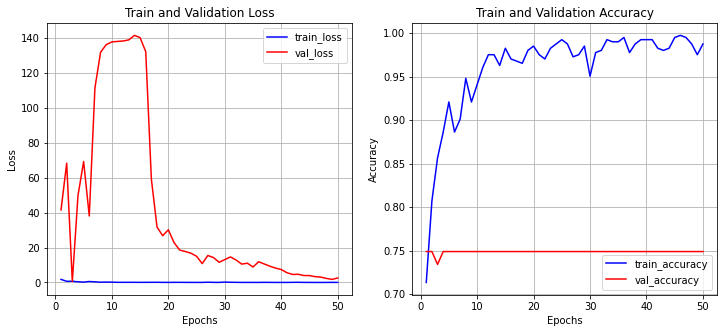

In [192]:
history_dict = hist.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

## confusion_matrix

In [195]:
y_pred.shape

(271,)

In [197]:
y_val.shape

(271, 2)

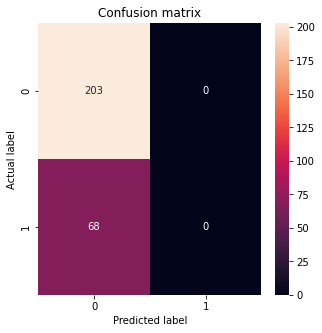

In [198]:
# 검증 데이터셋에 대한 예측 생성
y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)

# y_val을 원-핫 인코딩에서 정수 레이블로 변환
y_val_label = np.argmax(y_val, axis=1)

# confusion matrix 생성
cm = confusion_matrix(y_val_label, y_pred)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## validation data에 대해서 모델 평가

In [199]:
test_score=model.evaluate(x_val, y_val)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1]*100))

9/9 [==============================] - 0s 42ms/step - loss: 2.5657 - accuracy: 0.7491
Test loss 2.5657, accuracy 74.91%


In [ ]:
# 일반적으로 model.evaluate는 테스트 데이터셋에 대한 성능을 평가하는 데 사용됩니다. 
# 검증 데이터셋은 model.fit의 validation_data 인자를 통해 이미 사용되었기 때문에, 
# 모델이 새로운 데이터에 대해 얼마나 잘 일반화되는지 평가하기 위해 별도의 테스트 데이터셋을 사용하는 것이 좋습니다.

# 따라서 가능하다면, model.evaluate를 호출할 때는 검증 데이터셋 대신 테스트 데이터셋을 사용하는 것이 좋습니다.

In [ ]:
# 그럼 model.evaluate에 검증 데이터셋을 써도 괜찮아? 
# 아니면 model.evaluate에 사용할 테스트 데이터셋을 여러개 만드는 것이 더 나아?

# model.evaluate 함수는 모델의 성능을 평가하는 데 사용됩니다. 
# 이 함수를 사용할 때 어떤 데이터셋을 사용할지는 주로 실험의 목적과 데이터셋의 특성에 따라 달라집니다.

# 검증 데이터셋을 사용하는 경우: 모델 학습 도중에 검증 데이터셋을 사용하여 모델의 성능을 평가하고, 
#     과적합을 감지하는 등의 목적으로 사용할 수 있습니다. 
#     이 경우, model.evaluate 함수를 사용하여 검증 데이터셋에 대한 모델의 성능을 계속 모니터링할 수 있습니다.

# 테스트 데이터셋을 사용하는 경우: 모델 학습이 완료된 후에는 테스트 데이터셋을 사용하여 모델의 최종 성능을 평가하는 것이 일반적입니다. 
#     이는 모델이 학습 도중에 "보지 못한" 데이터에 대해 얼마나 잘 일반화되는지를 평가하는 것이기 때문에, 
#     이 경우에는 model.evaluate 함수를 사용하여 테스트 데이터셋에 대한 모델의 성능을 평가합니다.

# 따라서, model.evaluate에 사용할 데이터셋을 선택할 때는 실험의 목적과 단계를 고려해야 합니다. 
# 일반적으로, 검증 데이터셋은 모델 학습 도중에 성능을 평가하고 모델을 조정하는 데 사용되며, 
# 테스트 데이터셋은 모델 학습이 완료된 후에 최종적으로 모델 성능을 평가하는 데 사용됩니다.

# 테스트 데이터셋을 여러 개 만드는 것은 일반적으로 권장되지 않습니다. 이는 데이터를 불필요하게 분할하고, 
# 사용 가능한 학습 데이터를 줄이며, 결과적으로 모델 성능에 부정적인 영향을 미칠 수 있습니다. 
# 대신, 테스트 데이터셋은 가능한 한 다양한 케이스를 포함하도록 선택하거나 구성하는 것이 중요합니다.

In [201]:
# y_val_label = np.argmax(y_val, axis=1)

print(y_pred)
print(y_val_label)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0
 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1
 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0
 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0

## classification_report

In [203]:
from sklearn.metrics import classification_report

print(classification_report(y_val_label, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       203
           1       0.00      0.00      0.00        68

    accuracy                           0.75       271
   macro avg       0.37      0.50      0.43       271
weighted avg       0.56      0.75      0.64       271



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# case 3. 362장(웜) + 362장(쿨) 적용
### 문제 웜톤 데이터를 어떻게 362만 가지고 올 것인가


warm 폴더에는 1881개의 파일이 있음, 다 다운받아 그 중에서 랜덤으로 176개를 가지고 오려고 하기엔     
시간이 너무 오래 걸릴 것 같아 우선 내림차순 정렬시 위에서부터 176개를 선택해 다운받음   


warm_1 05번  + cool, cool_1 01 02 03 04 적용      
warm_1(05번) 362장 + cool_1 186장 + cool 176장 "총 724장"      
224*224 resize       

6:4 random state = 42      
dense layer 2, softmax, categorical_crossentropy, y_train y_val -> 원핫인코딩      
데이터 증강 0, epochs = 10, batch_size=32      

In [61]:
from PIL import Image

def load_data(img_path, number_of_data=724):  # warm_1 362 + cool_1 186 + cool 176
    # 웜톤 : 0, 쿨톤 : 1
    img_size=224
    color=3
    #이미지 데이터와 라벨(웜톤 : 0, 쿨톤 : 1) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    warm_files = list(glob.iglob(img_path + '/warm_1/*.jpg')) + list(glob.iglob(img_path + '/warm_1/*.JPG'))     
    # 리스트에서 무작위로 362개 선택
    warm_files = random.sample(warm_files, 362)
    for file in warm_files:
        img = Image.open(file)  # 이미지 열기
        img = img.resize((img_size, img_size))  # 이미지 크기 조정
        img = np.array(img, dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 웜톤 : 0
        idx=idx+1

    cool_files = (list(glob.iglob(img_path + '/cool_1/*.jpg')) + 
              list(glob.iglob(img_path + '/cool_1/*.JPG')) +
              list(glob.iglob(img_path + '/cool/*.jpg')) + 
              list(glob.iglob(img_path + '/cool/*.JPG')))
    for file in cool_files:
        img = Image.open(file)  # 이미지 열기
        img = img.resize((img_size, img_size))  # 이미지 크기 조정
        img = np.array(img, dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 쿨톤 : 1
        idx=idx+1  
    
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/aiffelthon"
(x_train, y_train)=load_data(image_dir_path)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 724 입니다.
x_train shape: (724, 224, 224, 3)
y_train shape: (724,)


## train data, validation data 나누기, 정규화

In [62]:
# x_train과 y_train을 훈련 세트와 검증 세트로 분할
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42)

In [63]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

In [64]:
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_val shape: {}".format(x_val.shape))
print("y_val shape: {}".format(y_val.shape))

x_train shape: (434, 224, 224, 3)
y_train shape: (434,)
x_val shape: (290, 224, 224, 3)
y_val shape: (290,)


## 데이터 증강

In [65]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 증강을 위한 ImageDataGenerator 인스턴스 생성
datagen = ImageDataGenerator(
    rescale=1./255,        # 이미지 픽셀 값을 [0,1] 범위로 스케일링
    rotation_range=20,     # 0-20도 범위에서 랜덤하게 이미지를 회전
    width_shift_range=0.2, # 이미지를 수평으로 랜덤하게 이동 (전체 너비의 20% 내에서)
    height_shift_range=0.2,# 이미지를 수직으로 랜덤하게 이동 (전체 높이의 20% 내에서)
    horizontal_flip=True   # 이미지를 랜덤하게 수평으로 뒤집기
)

# ImageDataGenerator를 학습 데이터에 적용
datagen.fit(x_train)

## MobileNetV2 모델 쌓기 

In [66]:
# MobileNetV2 모델 불러오기
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 모델 생성
model = Sequential()
model.add(base_model)  # MobileNetV2를 기본 모델로 추가
model.add(Flatten())   # 피처를 1D 벡터로 평탄화
model.add(Dense(2, activation='softmax'))  # 출력 레이어 추가

In [67]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_3 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 125442    
Total params: 2,383,426
Trainable params: 2,349,314
Non-trainable params: 34,112
_________________________________________________________________


In [70]:
y_val

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0], dtype=int32)

In [71]:
from tensorflow.keras.utils import to_categorical

# 레이블을 원-핫 인코딩 형태로 변환
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [72]:
y_val

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.

In [73]:
# 모델 컴파일
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# 학습 데이터에 데이터 증강 적용
train_generator = datagen.flow(x_train, y_train, batch_size=32)

# 모델 학습
model.fit(train_generator, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
14/14 [==============================] - 11s 486ms/step - loss: 2.1349 - accuracy: 0.6889 - val_loss: 26.5241 - val_accuracy: 0.4586
Epoch 2/10
14/14 [==============================] - 5s 329ms/step - loss: 0.6399 - accuracy: 0.8502 - val_loss: 14.4185 - val_accuracy: 0.4586
Epoch 3/10
14/14 [==============================] - 5s 363ms/step - loss: 0.7166 - accuracy: 0.8779 - val_loss: 21.5731 - val_accuracy: 0.4586
Epoch 4/10
14/14 [==============================] - 5s 337ms/step - loss: 0.2765 - accuracy: 0.8894 - val_loss: 31.5332 - val_accuracy: 0.4586
Epoch 5/10
14/14 [==============================] - 5s 328ms/step - loss: 0.1440 - accuracy: 0.9493 - val_loss: 10.5757 - val_accuracy: 0.5517
Epoch 6/10
14/14 [==============================] - 5s 329ms/step - loss: 0.4359 - accuracy: 0.8963 - val_loss: 36.7481 - val_accuracy: 0.4586
Epoch 7/10
14/14 [==============================] - 5s 366ms/step - loss: 0.5128 - accuracy: 0.8664 - val_loss: 45.1090 - val_accuracy: 0.541

## validation data에 대해 모델 평가

In [74]:
test_score=model.evaluate(x_val, y_val)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1]*100))

10/10 [==============================] - 0s 41ms/step - loss: 47.9078 - accuracy: 0.4586
Test loss 47.9078, accuracy 45.86%


## 새로운 연예인 이미지로 확률이 어떻게 나오는지 확인

In [75]:
def load_and_preprocess_image(img_path):
    # 이미지 불러오기
    img = image.load_img(img_path, target_size=(224, 224))
    # 이미지를 배열로 변환
    img_array = image.img_to_array(img)
    # 이미지 전처리 (스케일링 등)
    img_array = preprocess_input(img_array)
    return img_array

In [79]:
# 새로운 이미지 불러오기 (예: 'new_image.jpg')
new_image = load_and_preprocess_image('서현진.jpg')

# 이미지를 모델의 입력 형태에 맞게 변환
new_image = np.expand_dims(new_image, axis=0)

# 이미지에 대한 예측 수행
predictions = model.predict(new_image)

# 예측 결과 출력
print(predictions)

# 확률을 퍼센트로 변환
predictions_percent = predictions * 100

# 예측 결과 출력
print(predictions_percent)

[[0. 1.]]
[[  0. 100.]]


# 한 줄 정리

In [204]:
!pip install IPython # 주피터에 이미지를 넣기 위해 패키지 설치 
from IPython.display import Image

case 1.          

05번만 적용      
warm_1(05번) 490장 + cool_1 186장 "총 676장"     
6:4 random state = 42      
dense layer 1, sigmoid, binary_crossentropy     
데이터 증강 0, epochs = 30, batch_size=32      
confusion matrix, cla      

**loss: 1.0410 - accuracy: 0.8081**      

             precision    recall  f1-score   support     

           0       0.82      0.96      0.88       203     
           1       0.74      0.37      0.49        68     

    accuracy                           0.81       271     
   macro avg       0.78      0.66      0.69       271     
weighted avg       0.80      0.81      0.78       271     

-----------------------------------------------------------------------

case 2.     
 
05번만 적용      
warm_1(05번) 490장 + cool_1 186장 "총 676장"      
6:4 random state = 42      
dense layer 2, softmax, categorical_crossentropy, y_train y_val -> 원핫인코딩     
데이터 증강 0, epochs = 50, batch_size=32       

**loss: 2.5657 - accuracy: 0.7491**      

              precision    recall  f1-score   support      

           0       0.75      1.00      0.86       203      
           1       0.00      0.00      0.00        68       

    accuracy                           0.75       271      
   macro avg       0.37      0.50      0.43       271       
weighted avg       0.56      0.75      0.64       271      

-----------------------------------------------------------------------

case 3.      

warm_1(05번)에서 무작위 352장 + cool_1(05번) 186장 + cool(01~04번) 176장 = "총 724장"      
6:4 random state = 42       
dense layer 2, softmax, categorical_crossentropy      
데이터 증강 0, epochs = 10, batch_size=32       

**loss: 47.9078 - accuracy: 0.4586**      

# 그림과 함께 정리

## case 1         

05번만 적용      
warm_1(05번) 490장 + cool_1 186장 "총 676장"     
6:4 random state = 42      
dense layer 1, sigmoid, binary_crossentropy     
데이터 증강 0, epochs = 30, batch_size=32      
confusion matrix, cla      

**loss: 1.0410 - accuracy: 0.8081**      

             precision    recall  f1-score   support     

           0       0.82      0.96      0.88       203     
           1       0.74      0.37      0.49        68     

    accuracy                           0.81       271     
   macro avg       0.78      0.66      0.69       271     
weighted avg       0.80      0.81      0.78       271   

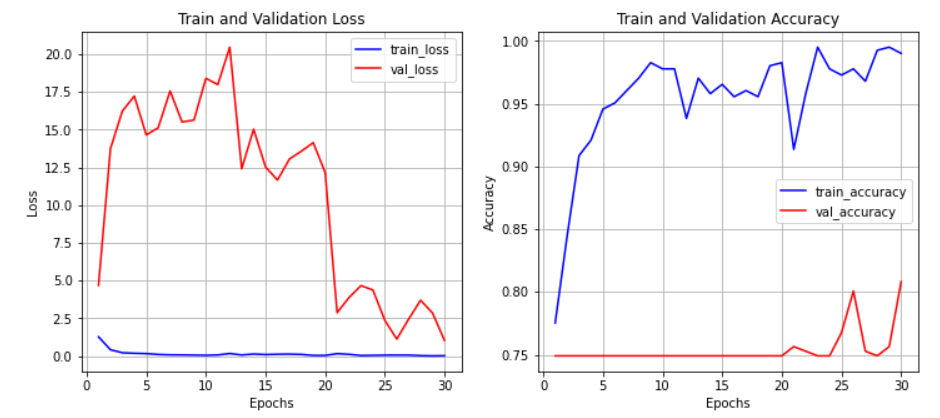

In [205]:
Image("07.PNG")

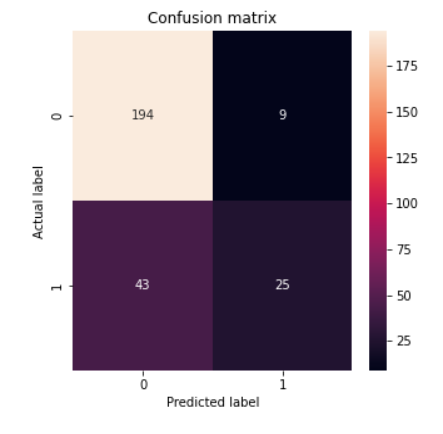

In [206]:
Image("08.PNG")

## case 2.     
 
05번만 적용      
warm_1(05번) 490장 + cool_1 186장 "총 676장"      
6:4 random state = 42      
dense layer 2, softmax, categorical_crossentropy, y_train y_val -> 원핫인코딩     
데이터 증강 0, epochs = 50, batch_size=32       

**loss: 2.5657 - accuracy: 0.7491**      

              precision    recall  f1-score   support      

           0       0.75      1.00      0.86       203      
           1       0.00      0.00      0.00        68       

    accuracy                           0.75       271      
   macro avg       0.37      0.50      0.43       271       
weighted avg       0.56      0.75      0.64       271   

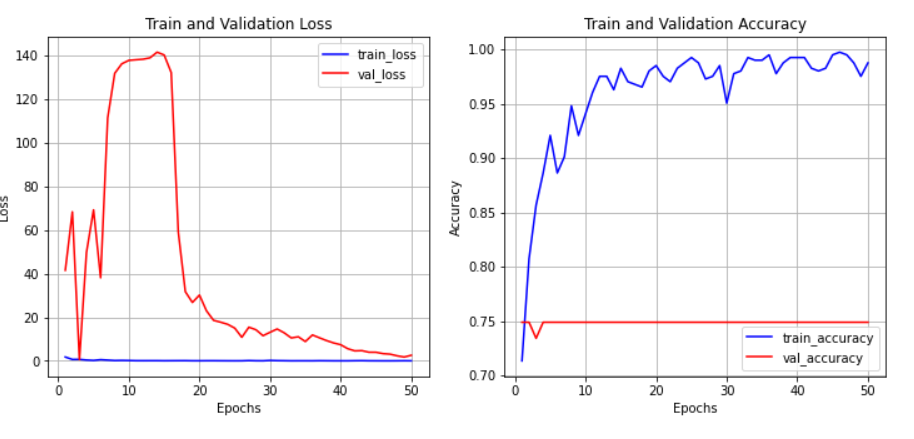

In [207]:
Image("09.PNG")

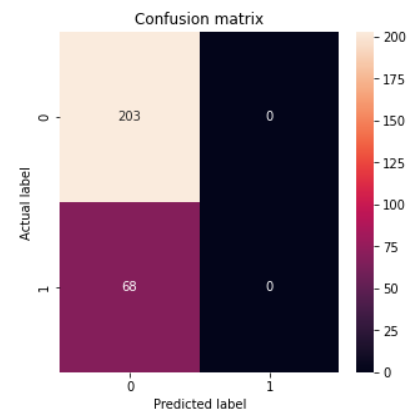

In [208]:
Image("10.PNG")